In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr, norm, nbinom, poisson, gamma
from scipy.special import gamma as gamma_func
from scipy.integrate import quad
from scipy.optimize import minimize
import seaborn as sns
from itertools import combinations
import gc
print(os.getcwd())

/Users/misha/Documents/metaanalysis/clonal_expansions/rebuttal1


<h1>Overdispersion of per-site mutaion rates</h1>

In [19]:
data_dir = "/Users/misha/Documents/metaanalysis/clonal_expansions/Roulette_check/"

# Frequency of MRs of synonymous variants
df_MR_freq = pd.read_table(data_dir + "Syn_rate_NB_v1", sep=" ")
df_MR_freq = df_MR_freq[df_MR_freq["rec"] == 0].reset_index(drop=True)
MR_cnt_dict = {float(df_MR_freq["Roul"][i]) : df_MR_freq["muts"][i] for i in range(len(df_MR_freq))}

# Histones that must be blacklisted in the population analyses
hists = np.array(pd.read_table(data_dir + "Histones.txt")["Ensembl gene ID"])
print(hists)


['ENSG00000189060' 'ENSG00000124610' 'ENSG00000184897' 'ENSG00000216331'
 'ENSG00000187837' 'ENSG00000124575' 'ENSG00000168298' 'ENSG00000184357'
 'ENSG00000187475' 'ENSG00000187166' 'ENSG00000178804' 'ENSG00000188662'
 'ENSG00000274183' 'ENSG00000277858' 'ENSG00000277745' 'ENSG00000164508'
 'ENSG00000218690' 'ENSG00000196787' 'ENSG00000274997' 'ENSG00000196747'
 'ENSG00000276368' 'ENSG00000275221' 'ENSG00000276903' 'ENSG00000278677'
 'ENSG00000288825' 'ENSG00000288859' 'ENSG00000184260' 'ENSG00000184270'
 'ENSG00000181218' 'ENSG00000216436' 'ENSG00000242387' 'ENSG00000278463'
 'ENSG00000234816' 'ENSG00000180573' 'ENSG00000196866' 'ENSG00000277075'
 'ENSG00000218281' 'ENSG00000246705' 'ENSG00000285944' 'ENSG00000249467'
 'ENSG00000229674' 'ENSG00000187516' 'ENSG00000285989' 'ENSG00000188486'
 'ENSG00000164032' 'ENSG00000105968' 'ENSG00000113648' 'ENSG00000099284'
 'ENSG00000146047' 'ENSG00000278588' 'ENSG00000124635' 'ENSG00000197903'
 'ENSG00000234289' 'ENSG00000185130' 'ENSG000002737

2399996.8524000007 7741.0


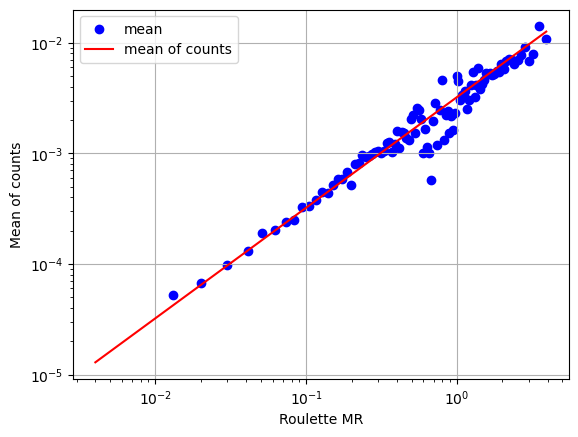

In [ ]:
# Calculate overdispersion of recurrence within each bin
# But first, construct the distributions of recurrences for each MR

SYN_df = pd.read_csv(data_dir + "Syn_rec", sep=" ")
SYN_df["Obj_recurr"] = SYN_df["NDD"] # + SYN_df["ASD"]

#MRs = sorted(SYN_df["Roul"].unique())
MRs = sorted(MR_cnt_dict.keys())


def bin_count_moments(bin_count_dict):
    values = np.array(sorted(bin_count_dict.keys()))
    Ps = np.array([bin_count_dict[k] for k in values])
    #print(bin_count_dict, Ps)
    Ps = Ps / np.sum(Ps)

    mean = np.sum(values * Ps)
    var = np.sum((values - mean) ** 2 * Ps)

    if mean == 0:
        mean = np.nan
        var = np.nan

    return mean, var



bin_count_dict = {}
#print(MRs)
cond_avgs = []
cond_vars = []
MR_probs = []

MR_total_val = 0
de_novo_total_val = 0

for MR in MRs:
    MR_df = SYN_df[SYN_df["Roul"] == MR].reset_index(drop=True)
    recurr_vals = MR_df["Obj_recurr"].unique()
    bin_count_dict[MR] = {}
    poly_poss_n = 0
    for i in recurr_vals:
        if i == 0:
            continue
        k_MR_df = MR_df[MR_df["Obj_recurr"] == i].reset_index(drop=True)
        k = len(k_MR_df)
        bin_count_dict[MR][int(i)] = int(k)
        poly_poss_n += k
    
    MR_probs.append(MR_cnt_dict[MR])

    bin_count_dict[MR][0] = int(MR_cnt_dict[MR] - poly_poss_n)

    cond_avg, cond_var = bin_count_moments(bin_count_dict[MR])
    #print(MR, cond_var/cond_avg)

    cond_avgs.append(cond_avg)
    cond_vars.append(cond_var)

    MR_total_val += MR_cnt_dict[MR] * MR
    de_novo_total_val += MR_cnt_dict[MR] * cond_avg if not np.isnan(cond_avg) else 0

print(MR_total_val, de_novo_total_val)
plt.scatter(MRs, cond_avgs, c="blue", label="mean")

x = np.array([np.min(MRs), np.max(MRs)])
plt.plot(x, x * de_novo_total_val / MR_total_val, c="red", label="mean of counts")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Roulette MR")
plt.ylabel("Mean of counts")
plt.legend()
plt.grid()
plt.show()

In [343]:
# Normalize the mutation rates by the amount of observed counts

norm_fac = de_novo_total_val / MR_total_val

MRs_norm = np.array(MRs) * norm_fac

total_mean = 0
total_var = 0

for MR in MRs:
    bcd = bin_count_dict[MR]
    vals = np.array(sorted(bcd.keys()))
    Ps = np.array([bcd[k] for k in vals])
    Ps = Ps / np.sum(Ps)

    var = np.sum((vals - MRs_norm[MRs.index(MR)]) ** 2 * Ps) * MR_cnt_dict[MR]
    mean = MRs_norm[MRs.index(MR)] * MR_cnt_dict[MR]

    total_mean += mean
    total_var += var

print("Total mean", total_mean)
print("Total var", total_var)
print("Total var / Total mean", total_var / total_mean)
print("Variance inflation gamma", total_var / total_mean - 1)



Total mean 7740.999999999995
Total var 7772.364070578935
Total var / Total mean 1.0040516820280248
Variance inflation gamma 0.00405168202802475


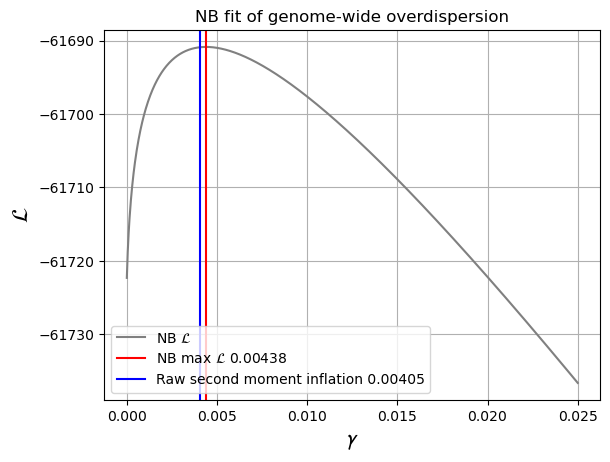

In [347]:
# Draw the gamma likelihood profile assuming a NB fit

def NB_gamma_LL(MRs, bin_count_dict, MRs_norm, MR_cnt_dict, gamma):
    LL = 0
    for MR in MRs:
        NB_mean = MRs_norm[MRs.index(MR)]
        NB_r = NB_mean / gamma
        NP_p = 1 / (1 + gamma)

        for k, cnt in bin_count_dict[MR].items():
            LL += cnt * nbinom.logpmf(k, NB_r, NP_p)
    return LL

gamma_vals = np.linspace(1e-8, 0.025, 1000)
LLs = [NB_gamma_LL(MRs, bin_count_dict, MRs_norm, MR_cnt_dict, gamma) for gamma in gamma_vals]
max_LL_vgamma = gamma_vals[np.argmax(LLs)]
mu2_infl = total_var / total_mean - 1

plt.plot(gamma_vals, LLs, color="grey", label=r"NB $\mathcal{L}$")
plt.axvline(max_LL_vgamma, c="red", label=r"NB max $\mathcal{L}$" + f" {max_LL_vgamma:.5f}")
plt.axvline(mu2_infl, c="blue", label=f"Raw second moment inflation {mu2_infl:.5f}")
plt.xlabel(r"$\mathcal{\gamma}$", fontsize=16)
plt.ylabel(r"$\mathcal{L}$", fontsize=16)
plt.title("NB fit of genome-wide overdispersion")
plt.legend()
plt.grid()

In [338]:
# Now, let's further decompose the variance into the Poisson part, gene-specific part and the between-gene part
# For that, we need some additional information about the counts of specific MRs for each gene
gc.collect()

SYN_df = pd.read_csv(data_dir + "Syn_rec", sep=" ")
Per_gene_MR_cnts = pd.read_table(f"gene_MR_pair_counts.txt.gz", compression="gzip", sep="\t", header=None)
#print(Per_gene_MR_cnts)

ENS2muttarg_dict = {}
for i in range(len(Per_gene_MR_cnts)):
    if not ENS2muttarg_dict.get(Per_gene_MR_cnts[1][i]):
        ENS2muttarg_dict[Per_gene_MR_cnts[1][i]] = 0
    ENS2muttarg_dict[Per_gene_MR_cnts[1][i]] += Per_gene_MR_cnts[0][i] * Per_gene_MR_cnts[2][i] * de_novo_total_val / MR_total_val

print(len(ENS2muttarg_dict))

# Now, let's calculate the mean and variance of the counts for each gene
ks = []
mts = []
for ENS_ID in sorted(ENS2muttarg_dict.keys()):
    if bin_count_dict.get(ENS_ID):
        k = np.sum([bin_count_dict[ENS_ID][i] for i in bin_count_dict[ENS_ID].keys() if i > 0])
    else:
        k = 0
    ks.append(k)
    mts.append(ENS2muttarg_dict[ENS_ID])


17841


In [341]:
gc.collect()
ks = np.array(ks)
mts = np.array(mts)
total_mean = np.mean(mts)
total_var = np.mean(np.power(ks - mts, 2))
print("Total mean", total_mean)
print("Total var", total_var)
print("Total var / Total mean", total_var / total_mean)

Total mean 0.43679088518444836
Total var 0.4213435508777245
Total var / Total mean 0.9646344856756781


Bin counts {0.004: {0: 77}, 0.013: {2: 1, 1: 46, 0: 914288}, 0.02: {1: 210, 0: 3098948}, 0.03: {2: 2, 1: 218, 0: 2250398}, 0.041: {1: 190, 0: 1461384}, 0.051: {1: 223, 3: 1, 0: 1192746}, 0.062: {1: 238, 0: 1176653}, 0.073: {2: 2, 1: 262, 0: 1121402}, 0.083: {1: 269, 0: 1078731}, 0.094: {1: 352, 0: 1064805}, 0.105: {1: 335, 0: 1012242}, 0.117: {3: 1, 1: 341, 2: 1, 0: 912299}, 0.128: {1: 362, 0: 810618}, 0.139: {1: 301, 2: 1, 0: 697074}, 0.151: {1: 285, 2: 1, 0: 552727}, 0.163: {1: 250, 0: 426423}, 0.174: {1: 188, 2: 1, 0: 322285}, 0.186: {2: 1, 1: 161, 0: 238551}, 0.198: {1: 90, 0: 173563}, 0.211: {1: 105, 0: 131118}, 0.223: {1: 81, 0: 99696}, 0.23: {0: 2}, 0.236: {1: 75, 2: 1, 0: 78958}, 0.248: {1: 59, 0: 63746}, 0.261: {1: 46, 0: 48124}, 0.274: {1: 40, 0: 40105}, 0.288: {1: 34, 0: 33256}, 0.301: {1: 29, 0: 27485}, 0.315: {1: 24, 0: 23649}, 0.329: {1: 21, 0: 20003}, 0.342: {1: 25, 0: 20075}, 0.357: {1: 20, 0: 15630}, 0.371: {1: 15, 0: 14601}, 0.386: {1: 12, 0: 9833}, 0.4: {1: 15, 0: 94

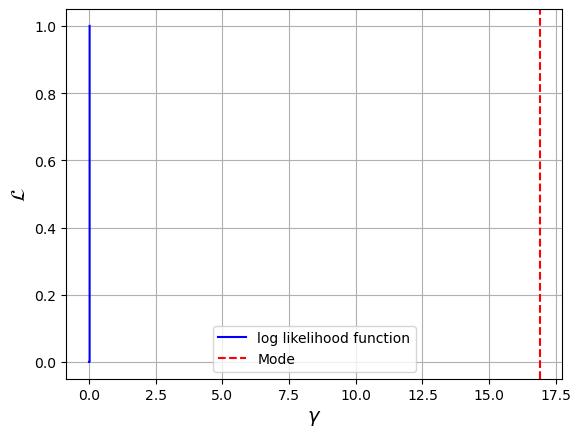

In [259]:
# fit a single Negative Binomial distribution

def singleNB_recurr_fit(bin_count_dict, r_0 = 0.1, p_0 = 0.99):

    def objective_func(params):
        r, p = params
        LL = 0
        for MR, dist_dict in bin_count_dict.items():
            for k, freq in dist_dict.items():
                LL += freq * nbinom.logpmf(k, r*MR, p)
        #print(r, p, LL)
        return -LL
    
    initial_guess = [r_0, p_0]
    result = minimize(objective_func, initial_guess, method='L-BFGS-B', bounds = [(1e-8, 1e8), (0.1, 0.99999)])
    print(f"Max LL | r: {result.x[0]}, p: {result.x[1]}, LL: {-result.fun}, mean = {result.x[0] * (1 - result.x[1]) / result.x[1]}")
    return result.x[0], result.x[1]

def singleNB_var_infl_fit(bin_count_dict, gamma_0 = 0.01, mean_fac = 0.00039336):

    def objective_func(gamma):
        gamma = gamma[0]
        p = 1 / (1 + gamma)
        r = mean_fac / gamma
        LL = 0
        for MR, dist_dict in bin_count_dict.items():
            for k, freq in dist_dict.items():
                LL += freq * nbinom.logpmf(k, r, p)
        #print(gamma, r, p, LL)
        return -LL
    
    initial_guess = gamma_0
    result = minimize(objective_func, initial_guess, method='L-BFGS-B', bounds = [(1e-8, 1e8)])

    print(f"Max LL | gamma: {result.x[0]}, LL: {-result.fun}")

    gamma_arr = np.linspace(1e-8, 0.025, 100)
    LL_arr = -np.array([objective_func([g]) for g in gamma_arr])
    plt.plot(gamma_arr, np.exp(LL_arr - np.max(LL_arr)), color="blue", label = "log likelihood function")
    # vertical line at max LL gamma
    plt.axvline(x=result.x[0], color='r', linestyle='--', label='Mode')
    plt.xlabel(r"$\gamma$", fontsize=14)
    plt.ylabel(r"$\mathcal{L}$", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()
    return result.x[0]

print("Bin counts", bin_count_dict)
r0, p0 = singleNB_recurr_fit(bin_count_dict)
gamma0 = (1 - p0)/p0
print("gamma initial", gamma0)
gamma_ML = singleNB_var_infl_fit(bin_count_dict, gamma_0 = 0.01, mean_fac = r0 * (1 - p0) / p0)

In [ ]:
# Composite model taking into account variation between genes



<h2>Separate fits for CpGs / non-CpGs</h2>

In [71]:
def doubleNB_recurr_fit(bin_count_dict, r1_0 = 0.1, p1_0 = 0.99, r2_0 = 0.1, p2_0 = 0.99, MR_thr = 1.0):
    
    def objective_func(params):
        r1, p1, r2, p2 = params
        LL = 0
        for MR, dist_dict in bin_count_dict.items():
            if MR < MR_thr:
                r = r1 * MR
                p = p1
            else:
                r = r2 * MR
                p = p2

            for k, freq in dist_dict.items():
                LL += freq * nbinom.logpmf(k, r, p)
        #print(r1, p1, r2, p2, LL)
        return -LL
    
    initial_guess = [r1_0, p1_0, r2_0, p2_0]
    result = minimize(objective_func,
                      initial_guess, 
                      method='L-BFGS-B', 
                      bounds = [(1e-8, 1e8), (0.1, 0.99999), (1e-8, 1e8), (0.1, 0.99999)])
    print(f"MR thr={MR_thr} Max LL | r1: {result.x[0]}, p1: {result.x[1]}, r2: {result.x[2]}, p2: {result.x[3]}, LL: {-result.fun}, mean = {result.x[0] * (1 - result.x[1]) / result.x[1]}")
    return result

LL_arr = []
r1_arr = []
p1_arr = []
r2_arr = []
p2_arr = []
for MR in sorted(MRs):
    if len(LL_arr) == 0:
        r1_0, p1_0, r2_0, p2_0 = 0.1, 0.99, 0.1, 0.99
    else:
        r1_0, p1_0, r2_0, p2_0 = r1_arr[-1], p1_arr[-1], r2_arr[-1], p2_arr[-1]

    res_obj = doubleNB_recurr_fit(bin_count_dict, r1_0, p1_0, r2_0, p2_0, MR_thr = MR)
    LL = -res_obj.fun
    r1, p1, r2, p2 = res_obj.x
    LL_arr.append(LL)
    r1_arr.append(r1)
    p1_arr.append(p1)
    r2_arr.append(r2)
    p2_arr.append(p2)

LL_arr, r1_arr, p1_arr, r2_arr, p2_arr = np.array(LL_arr), np.array(r1_arr), np.array(p1_arr), np.array(r2_arr), np.array(p2_arr)


MR thr=0.004 Max LL | r1: 0.1, p1: 0.99, r2: 0.7342373566898335, p2: 0.9956263526266742, LL: -61690.84077118978, mean = 0.001010101010101011
MR thr=0.013 Max LL | r1: 0.09999999990777135, p1: 0.9900000003165783, r2: 0.7342373590877785, p2: 0.9956263242447004, LL: -61690.840089355705, mean = 0.0010101009768687945
MR thr=0.02 Max LL | r1: 0.19057695155718446, p1: 0.9796592800531854, r2: 0.7345305870814024, p2: 0.9956328485285798, LL: -61688.754835179156, mean = 0.003956959811304901
MR thr=0.03 Max LL | r1: 0.1803707808228288, p1: 0.980919634224063, r2: 0.6952511586643352, p2: 0.9953940030816161, LL: -61690.53966577091, mean = 0.00350848362426071
MR thr=0.041 Max LL | r1: 0.2321545005820333, p1: 0.9855899092160634, r2: 0.8962111548187216, p2: 0.9964254355108241, LL: -61689.02421322449, mean = 0.003394279302176975
MR thr=0.051 Max LL | r1: 0.23214296145372934, p1: 0.9858657877070717, r2: 0.8962209510064887, p2: 0.9964244145417069, LL: -61690.277946410715, mean = 0.003328199376030089
MR thr

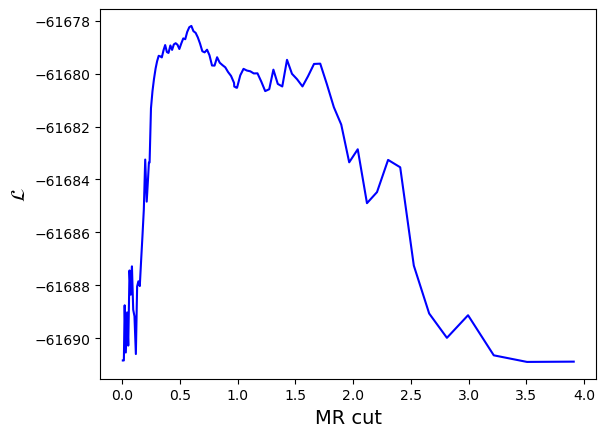

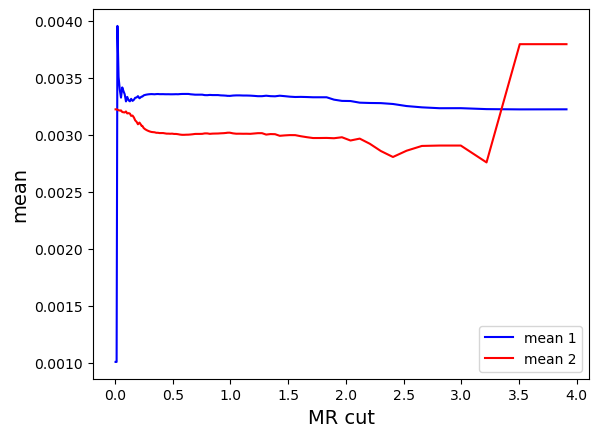

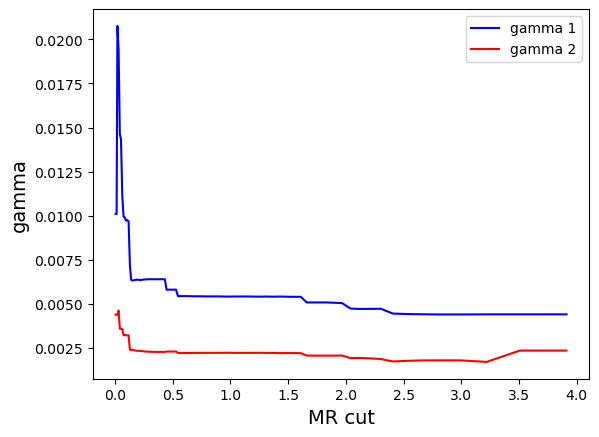

In [72]:
plt.plot(MRs, LL_arr, color="blue", label = "log likelihood function")
plt.xlabel("MR cut", fontsize=14)
plt.ylabel(r"$\mathcal{L}$", fontsize=14)
plt.show()

# plot the means and gammas
plt.plot(MRs, r1_arr * (1 - p1_arr) / p1_arr, color="blue", label = "mean 1")
plt.plot(MRs, r2_arr * (1 - p2_arr) / p2_arr, color="red", label = "mean 2")
plt.xlabel("MR cut", fontsize=14)
plt.ylabel("mean", fontsize=14)
plt.legend()
plt.show()

# plot the gammas
plt.plot(MRs, (1 - p1_arr) / p1_arr, color="blue", label = "gamma 1")
plt.plot(MRs, (1 - p2_arr) / p2_arr, color="red", label = "gamma 2")
plt.xlabel("MR cut", fontsize=14)
plt.ylabel("gamma", fontsize=14)
plt.legend()
plt.show()

<h1>Overdispersion of per-gene mutation rate estimates</h1>

In [11]:
wd = "/Users/misha/Documents/metaanalysis/clonal_expansions/Roulette_check/"
SYN_gnomad_file = "gnomad_sfs4_Roulette_QC_AN90_SYNSFS_STRATBY_GENES.txt.gz"
df = pd.read_csv(f"{wd}{SYN_gnomad_file}", sep="\t", compression="gzip", header=None)

# Remove histones
#df = df[~df[2].isin(hists)].reset_index(drop=True)
MRs = sorted(df[1].unique())
#print(MRs)
MR_ind_dict = {MR: i for i, MR in enumerate(MRs)}

L = len(MRs)

# ENS_ID -> [[by-MR counts of monomorphic vars], [by-MR counts of polymorphic vars]]
ENS2MR_info = {}

for i in range(len(df)):
    MR = df[1][i]
    ENS = df[2][i]
    if ENS2MR_info.get(ENS) is None:
        ENS2MR_info[ENS] = np.array([np.zeros(L), np.zeros(L)])
    if df[3][i] == 0:
        ENS2MR_info[ENS][0][MR_ind_dict[MR]] += df[0][i]
    elif df[3][i] > 0:
        ENS2MR_info[ENS][1][MR_ind_dict[MR]] += df[0][i]

df = None
gc.collect()

6090

/var/folders/lp/tg73n10s4nz06fzkwth8fm440000gp/T/ipykernel_3781/3888243490.py:10: RuntimeWarning: divide by zero encountered in log
  ms_NB = gamma_ML * np.log(1 - P_poly_arr) / np.log(p_ML)
/var/folders/lp/tg73n10s4nz06fzkwth8fm440000gp/T/ipykernel_3781/3888243490.py:13: RuntimeWarning: divide by zero encountered in log
  plt.scatter(MRs, -np.log(1 - P_poly_arr), color="red", label = "Polymorphic Poisson lambda")


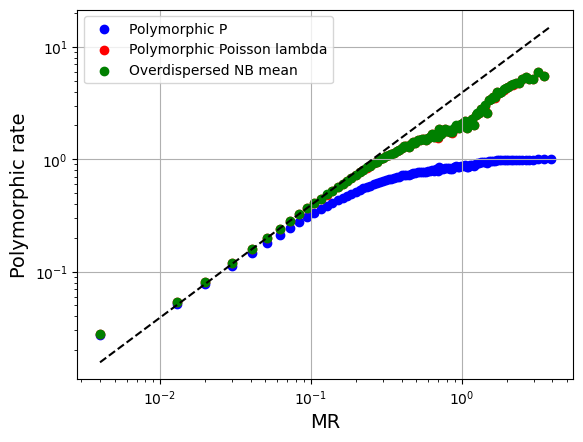

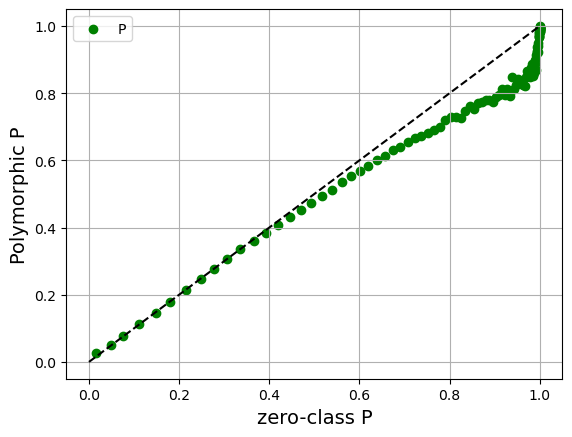

In [12]:
allgen_mono_arr = np.sum(np.array([ENS2MR_info[ENS][0] for ENS in ENS2MR_info.keys()]), axis=0)
allgen_poly_arr = np.sum(np.array([ENS2MR_info[ENS][1] for ENS in ENS2MR_info.keys()]), axis=0)

P_poly_arr = allgen_poly_arr / (allgen_poly_arr + allgen_mono_arr)

gamma_ML = 0.005591345101062893
#gamma_ML = np.array([0.005591345101062893] * (L // 2) + [1.9] * (L - L // 2))
p_ML = 1 / (1 + gamma_ML)

ms_NB = gamma_ML * np.log(1 - P_poly_arr) / np.log(p_ML)

plt.scatter(MRs, P_poly_arr, color="blue", label = "Polymorphic P")
plt.scatter(MRs, -np.log(1 - P_poly_arr), color="red", label = "Polymorphic Poisson lambda")
plt.scatter(MRs, ms_NB, color="green", label = "Overdispersed NB mean")

x = np.array([np.min(MRs), np.max(MRs)])
plt.plot(x, x * 3.9, color="black", linestyle="--")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("MR", fontsize=14)
plt.ylabel("Polymorphic rate", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.scatter(1 - np.exp(-np.array(MRs) * 3.9), P_poly_arr, color="green", label = "P")
plt.plot([0,1], [0,1], color="black", linestyle="--")
plt.xlabel("zero-class P", fontsize=14)
plt.ylabel("Polymorphic P", fontsize=14)
plt.legend()
plt.grid()
plt.show()

<h2>Per-gene estimates</h2>

beta_MR 3.9821526918514034


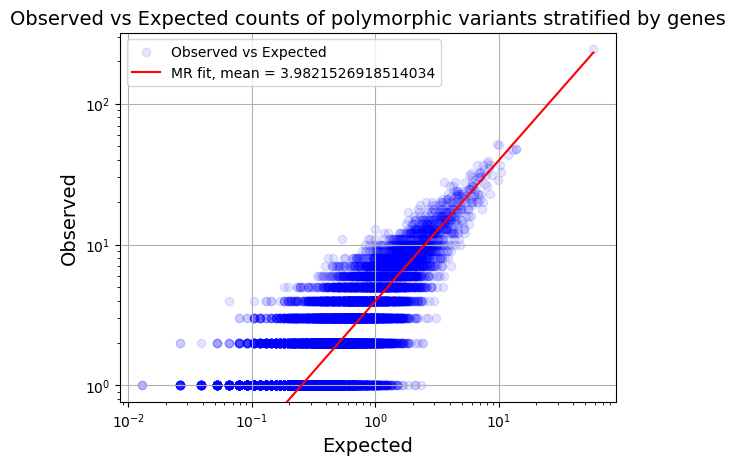

In [14]:
ENS_IDs = sorted(ENS2MR_info.keys())

gene_obs_arr = []
gene_exp_arr = []

t = 2

for ENS in ENS_IDs:
    exp_lam = np.sum(MRs[:t] * (ENS2MR_info[ENS][0][:t] + ENS2MR_info[ENS][1][:t]))
    obs_lam = np.sum(ENS2MR_info[ENS][1][:t])
    gene_obs_arr.append(obs_lam)
    gene_exp_arr.append(exp_lam)

beta_MR = np.sum(gene_obs_arr) / np.sum(gene_exp_arr)

plt.scatter(gene_exp_arr, gene_obs_arr, color="blue", label = "Observed vs Expected", alpha = 0.1)

x = [np.min(gene_exp_arr), np.max(gene_exp_arr)]
y = [beta_MR * i for i in x]
print("beta_MR", beta_MR)
plt.plot(x, y, color="red", label = f"MR fit, mean = {beta_MR}")

plt.xlabel("Expected", fontsize=14)
plt.ylabel("Observed", fontsize=14)
plt.title("Observed vs Expected counts of polymorphic variants stratified by genes", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()
    

In [16]:
# sample half of the points at random for each gene
def array_sample(array2d):
    """
    Sample half of the points in a 2D array without replacement.
    Args:
        array2d (np.ndarray): 2D array to sample from.
    Returns:
        sampled_array2d (np.ndarray): 2D array with half of the points sampled.
        remaining_array2d (np.ndarray): 2D array with the remaining points.
    """
    array2d = array2d.astype(np.int32)
    total_points = np.sum(array2d)
    sample_size = total_points // 2
    array2d_flat = array2d.flatten()
    points = np.concatenate([np.full(count, idx) for idx, count in enumerate(array2d_flat)])
    sampled_points = np.random.choice(points, size=sample_size, replace=False)
    sampled_array2d = np.bincount(sampled_points, minlength=array2d.size).reshape(array2d.shape)

    return sampled_array2d, array2d - sampled_array2d


# To estimate the distribution fit, compare the observed sample of probabilities under null
#    to the uniform expectation
def QQ_plot(p_arr, title="QQ plot", color="blue"):
    """
    Generate a QQ plot for the given p-values.
    Args:
        p_arr (np.ndarray): Array of p-values.
    """
    plt.figure(figsize=(5, 5))
    sorted_p = np.sort(p_arr)
    expected_p = np.linspace(0, 1, len(sorted_p))
    plt.scatter(-np.log10(expected_p), -np.log10(sorted_p), color=color)

    #plot the x=y line
    x = np.linspace(1/len(p_arr), 1, 2)
    y = -np.log10(x)
    plt.plot(y, y, color="grey",  linestyle="--", label="y=x")
    plt.xlabel(r"$P_U$", fontfamily="sans-serif", fontsize=16)
    plt.ylabel("P", fontfamily="sans-serif", fontsize=16)
    plt.title(title)
    #plt.grid()
    plt.legend()
    plt.savefig(f"{title}.pdf")
    plt.show()

In [17]:
# Split the polymrphic variants into two groups: the "training" group and the "testing" group

ENS_ID2MRs1, ENS_ID2MRs2 = {}, {}

for ENS_ID in ENS2MR_info.keys():
    #print(ENS_ID)

    sampled_array2d, remaining_array2d = array_sample(ENS2MR_info[ENS_ID])
    ENS_ID2MRs1[ENS_ID] = sampled_array2d
    ENS_ID2MRs2[ENS_ID] = remaining_array2d


/var/folders/lp/tg73n10s4nz06fzkwth8fm440000gp/T/ipykernel_3781/4101071097.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(expected_p), -np.log10(sorted_p), color=color)


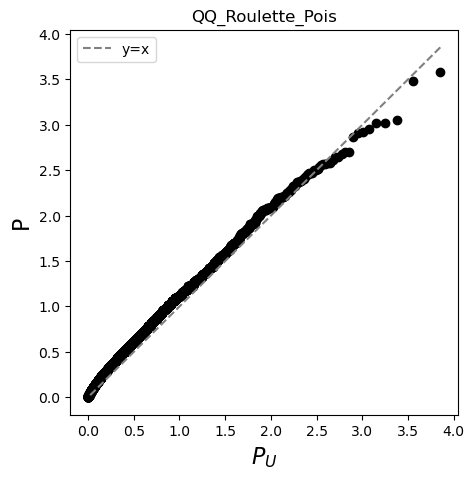

/var/folders/lp/tg73n10s4nz06fzkwth8fm440000gp/T/ipykernel_3781/4101071097.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(expected_p), -np.log10(sorted_p), color=color)


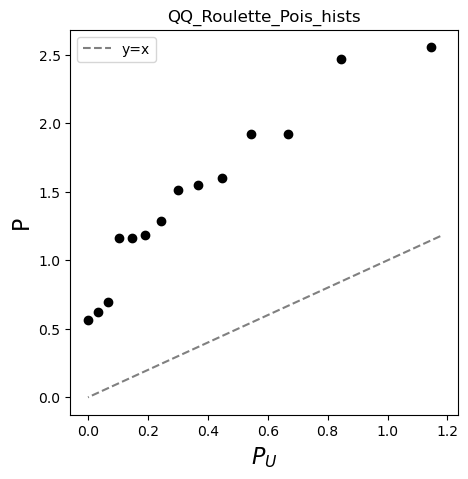

In [20]:
crit_ind_MR = t #len(MRs)

MRs_used = np.array(MRs[:crit_ind_MR])
MR_scalingUnder1_coeff = beta_MR #3.06

n_s = []
lams = []
n2_arr = []
p_Pois_arr = []
p_Pois_full = []
p_Pois_scal_arr = []
p_NB_arr = []

pi = 0.008

p_Pois_hists = []

for ENS_ID in ENS2MR_info.keys():

    ns1 = ENS_ID2MRs1[ENS_ID][:, :crit_ind_MR]
    ns2 = ENS_ID2MRs2[ENS_ID][:, :crit_ind_MR]

    n1 = np.sum(ns1[1])
    n2 = np.sum(ns2[1])

    if n1 == 0:
        continue
    if n2 == 0:
        continue

    lam1 = np.sum(MRs_used * MR_scalingUnder1_coeff * (ns1[0] + ns1[1]))
    lam2 = np.sum(MRs_used * MR_scalingUnder1_coeff * (ns2[0] + ns2[1]))

    #print(lam1/(np.sum(ns1[1]) + np.sum(ns1[0])), lam2)

    if ENS_ID not in hists:
        p_Pois_arr.append(poisson.sf(n2 + n1 - 1, lam2 + lam1))

    else:
        p_Pois_hists.append(poisson.sf(n2 + n1 - 1, lam2 + lam1))
    #else:
        #p_Pois_hists.append(np.nan)

QQ_plot(p_Pois_arr, fr"QQ_Roulette_Pois", color="black")
QQ_plot(p_Pois_hists, fr"QQ_Roulette_Pois_hists", color="black")


In [41]:
# Kornish-Fisher expansions

def kf_pol(Z, skew, kurt):
    """
    Calculate the Kornish-Fisher expansion for a given Z value.
    """
    # Calculate the Kornish-Fisher expansion
    kf = (Z) + ((1/6) * (Z**2 - 1) * skew) + ((1/24) * (Z**3 - 3*Z) * kurt) - ((1/36) * (2 * Z**3 - 5 * Z) * skew**2)
    
    return kf


def kornish_fisher_Z_map(precision, skew, kurt):
    Zs = np.linspace(-6, 6, precision)
    kf_Zs = kf_pol(Zs, skew, kurt)
    return Zs, kf_Zs


def S(k, m):
    """Count of surjections from k to m."""
    if m == 0:
        return 0
    if m == 1:
        return 1
    if m == 2:
        return 2 ** k - 2
    if m == 3:
        return 3 ** k - 3 * (2 ** k) + 3
    if m == 4:
        return 4 ** k - 4 * (3 ** k) + 6 * (2 ** k) - 4


def count_raw_moments(p_array, index_array, counts_array, degree):
    """
    Calculate the sum of products of all combinations of Bernoulli variables.
    Args:
        p_array (np.ndarray): Array of probabilities.
        index_array (np.ndarray): Array of indices with non-zero mutations.
        counts_array (np.ndarray): Array of counts of mutations.
        degree (int): Degree of the moment.
    """
    combs = combinations(index_array, degree)

    moment_val = 0
    for m in range(1, degree + 1):
        S_val = S(degree, m)
        combs = combinations(index_array, m)
        for comb in combs:
            add_val = S_val * np.prod(p_array[np.array(comb)] * counts_array[np.array(comb)])
            moment_val += add_val
            #print(p_array[np.array(comb)], counts_array[np.array(comb)], S_val, add_val)
        #* np.sum([np.prod(p_array[np.array(comb)] * counts_array[np.array(comb)]) for comb in combs])
    
    return moment_val


def bernoulli_moments(p_array, index_array, counts_array, excess_kurtosuis = True):
    """
    Calculate the moments of a Bernoulli distribution.
    """
    moments = []
    for i in range(1, 5):
        moment_val = count_raw_moments(p_array, index_array, counts_array, i)
        print(i, moment_val)
        moments.append(moment_val)
    
    mean_val = moments[0]
    variance_val = moments[1] - mean_val ** 2
    skewness_val = (moments[2] - 3 * mean_val * variance_val - mean_val ** 3) / (variance_val ** (3/2))
    #kurtosis_val = 0
    kurtosis_val = (moments[3] - 4 * mean_val * moments[2] + 6 * mean_val ** 2 * variance_val + 3 * mean_val ** 4) / (variance_val ** 2) 
    if excess_kurtosuis:
        kurtosis_val -= 3
        if kurtosis_val < 0:
            kurtosis_val = 0

    return mean_val, variance_val, skewness_val, kurtosis_val


index_array = np.array([i for i in range(len(MRs))])

for ENS_ID in ENS2MR_info.keys():
    counts_array = np.sum(ENS2MR_info[ENS_ID], axis=0)

    lams = np.array(MRs) * MR_scalingUnder1_coeff
    p_array = 1 - np.exp(-lams)

    iter_index_array = index_array[counts_array > 0]

    mean_val, variance_val, skewness_val, kurtosis_val = bernoulli_moments(p_array, iter_index_array, counts_array)

    print(ENS_ID, mean_val, variance_val, skewness_val, kurtosis_val, np.sum(ENS2MR_info[ENS_ID][1]))
    
    break

1 161.67182703029042
2 24740.14181958058
3 3578295.830277276
4 488487069.52522975
ENSG00000001167 161.67182703029042 -1397.6378357315625 nan 0 152.0


/var/folders/lp/tg73n10s4nz06fzkwth8fm440000gp/T/ipykernel_3781/1352594268.py:69: RuntimeWarning: invalid value encountered in scalar power
  skewness_val = (moments[2] - 3 * mean_val * variance_val - mean_val ** 3) / (variance_val ** (3/2))


In [42]:
161.67 * 161.67

26137.188899999997

/var/folders/lp/tg73n10s4nz06fzkwth8fm440000gp/T/ipykernel_15798/2822570535.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(expected_p), -np.log10(sorted_p), alpha=0.5, color="blue")


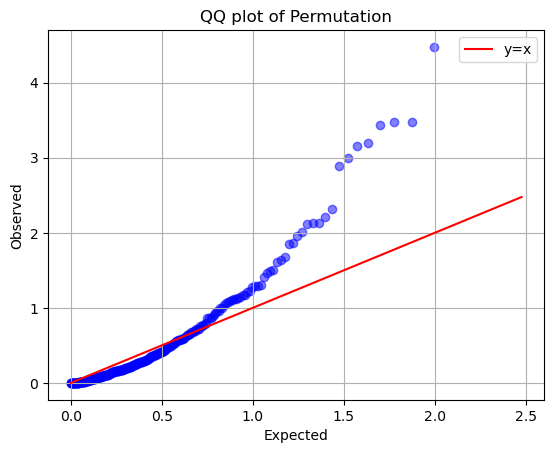

In [292]:
# Pseudo-Multinomial sampling 

samp_size = 30000

P_permut = []
i = 0
P_a = 1 - np.exp(-np.array(MRs) * 3.82)
for ENS_ID in ENS2MR_info.keys():
    i += 1
    if i > 300:
        break
    #print(ENS_ID)

    n_arr = ENS2MR_info[ENS_ID]

    Ns = np.sum(n_arr, axis=0)
    Poly_N = np.sum(n_arr[1])

    binomial_samples = np.array([np.random.binomial(n, p, size=samp_size) for n, p in zip(Ns, P_a)])
    binomial_sums = np.sum(binomial_samples, axis=0)
    #print(Poly_N, binomial_sums)

    P = np.sum(binomial_sums >= Poly_N) / samp_size
    P_permut.append(P)

QQ_plot(np.power(P_permut, 1), fr"QQ plot of Permutation")

In [236]:
# Example vectors
trial_numbers = np.array([10, 20, 15, 30])  # Number of trials for each sample
probabilities = np.array([0.5, 0.7, 0.3, 0.9])  # Probabilities of success for each sample

# Generate Binomial samples
binomial_samples = np.array([np.random.binomial(n, p, size=10) for n, p in zip(trial_numbers, probabilities)])

print("Trial numbers:", trial_numbers)
print("Probabilities:", probabilities)
print("Binomial samples:", binomial_samples.T)
print("Sums: ", np.sum(binomial_samples, axis=0))

Trial numbers: [10 20 15 30]
Probabilities: [0.5 0.7 0.3 0.9]
Binomial samples: [[ 7 13  1 27]
 [ 4 13  4 25]
 [ 6 12  1 25]
 [ 4 13  2 27]
 [ 6 14  3 27]
 [ 2 12  3 28]
 [ 2 14  5 27]
 [ 2 10  3 29]
 [ 6 15  4 25]
 [ 5 15  7 22]]
Sums:  [48 46 44 46 50 45 48 44 50 49]


      ensembl_gene_id    gene_name     P_val  poisson_lambda  count  \
0     ENSG00000002746        HECW1  0.363753        0.452169      1   
1     ENSG00000002822       MAD1L1  0.192407        0.213697      1   
2     ENSG00000002919        SNX11  0.101412        0.106931      1   
3     ENSG00000004399       PLXND1  0.056016        0.379017      2   
4     ENSG00000004487        KDM1A  0.231860        0.263783      1   
...               ...          ...       ...             ...    ...   
2234  ENSG00000277972        CISD3  0.021866        0.022109      1   
2235  ENSG00000278311       GGNBP2  0.001584        0.223922      3   
2236  ENSG00000278318       ZNF229  0.019534        0.019728      1   
2237  ENSG00000284862       CCDC39  0.195359        0.217359      1   
2238  ENSG00000285292  ABCF2-H2BE1  0.107623        0.113866      1   

          ratio  LOEUF  adjusted_p_values  
0      2.211562  0.470           1.000000  
1      4.679515  1.154           1.000000  
2      9.351844

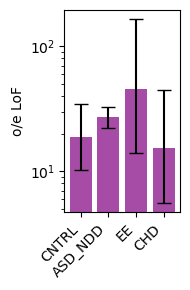

In [448]:
# Enrichment plot for the five regarded cohorts

blacklist = ["ENSG00000119772", #DNMT3A
             "ENSG00000171456", #ASXL1
             "ENSG00000170836", #PPM1D
             "ENSG00000115758"] #ODC1

set2 = ['ENSG00000064419', 'ENSG00000101752', 'ENSG00000111262', 'ENSG00000115758', 'ENSG00000117139', 
        'ENSG00000119772', 'ENSG00000134440', 'ENSG00000136158', 'ENSG00000137834', 'ENSG00000141376', 
        'ENSG00000145907', 'ENSG00000146830', 'ENSG00000148737', 'ENSG00000157933', 'ENSG00000170836', 
        'ENSG00000171456', 'ENSG00000171862', 'ENSG00000196712', 'ENSG00000256463']

set2 = np.array(set2)
set2 = set2[~np.isin(set2, blacklist)]

data_dir = "/Users/misha/Documents/metaanalysis/clonal_expansions/rebuttal1/"

CNTRL_file = "CNTRL_LoF_results.txt"
ASD_NDD_file = "ASD_NDD_LoF_results.txt"
EE_file = "EE_LoF_results.txt"
CHD_file = "CHD_LoF_results.txt"

dfs = {}
means = []
CIs = []

print(pd.read_csv(data_dir + ASD_NDD_file, sep="\t"))
# read the other files, update the data frame with per-gene lambdas and variant counts
df_ASD_NDD = pd.read_csv(data_dir + ASD_NDD_file, sep="\t")
for c in ["CNTRL", "ASD_NDD", "EE", "CHD"]:
    df = pd.read_csv(data_dir + f"{c}_LoF_results.txt", sep="\t")
    common_ENS_IDs = np.intersect1d(df["ensembl_gene_id"], df_ASD_NDD["ensembl_gene_id"])

    lambda_sum = np.sum(df["poisson_lambda"][df["ensembl_gene_id"].isin(common_ENS_IDs)])
    lambda_sum_ASDNDD = np.sum(df_ASD_NDD["poisson_lambda"][df_ASD_NDD["ensembl_gene_id"].isin(common_ENS_IDs)])

    scaling_fac = lambda_sum / lambda_sum_ASDNDD
    df_ASD_NDD[f"poisson_lambda_{c}"] = df_ASD_NDD["poisson_lambda"] * scaling_fac

    current_vc = {df["ensembl_gene_id"][i]: df["count"][i] for i in range(len(df))}

    vc_vec = [current_vc[s] if s in current_vc else 0 for s in df_ASD_NDD["ensembl_gene_id"]]
    df_ASD_NDD[f"count_{c}"] = vc_vec
    
print(df_ASD_NDD)

df_ASD_NDD = df_ASD_NDD[df_ASD_NDD["ensembl_gene_id"].isin(set2)].reset_index(drop=True)
for c in ["CNTRL", "ASD_NDD", "EE", "CHD"]:
    #df = pd.read_csv(data_dir + f"{c}_LoF_results.txt", sep="\t")
    #df_set2 = df[df["ensembl_gene_id"].isin(set2)].reset_index(drop=True)
    Pois_lam = np.sum(df_ASD_NDD[f"poisson_lambda_{c}"])
    count = np.sum(df_ASD_NDD[f"count_{c}"])

    gamma_shape = count + 1
    gamma_scale = 1

    CI_95_gamma_lower, CI_95_gamma_upper = gamma.ppf([0.025, 0.975], a=gamma_shape, scale=gamma_scale) 
    CI_95_gamma_lower = np.round(CI_95_gamma_lower, 2)
    CI_95_gamma_upper = np.round(CI_95_gamma_upper, 2)
    print(c, Pois_lam, count, count/Pois_lam, CI_95_gamma_lower/Pois_lam, CI_95_gamma_upper/Pois_lam)
    dfs[c] = pd.read_csv(data_dir + f"{c}_LoF_results.txt", sep="\t")

    means.append(count/Pois_lam)
    CIs.append((count/Pois_lam - CI_95_gamma_lower/Pois_lam, CI_95_gamma_upper/Pois_lam - count/Pois_lam))

# Plot the bar plot of means and CIs in the y-log scale

plt.figure(figsize=(2, 3))
plt.bar(range(len(means)), means, yerr=np.array(CIs).T, capsize=5, color='purple', alpha=0.7)
plt.xticks(range(len(means)), ["CNTRL", "ASD_NDD", "EE", "CHD"], rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("o/e LoF")
#plt.title("Enrichment of MRs in the five cohorts")
#plt.grid()
plt.tight_layout()
plt.savefig("/Users/misha/Documents/metaanalysis/clonal_expansions/rebuttal1/Cross_cohort_Enrichment_MRs.pdf")
plt.show()


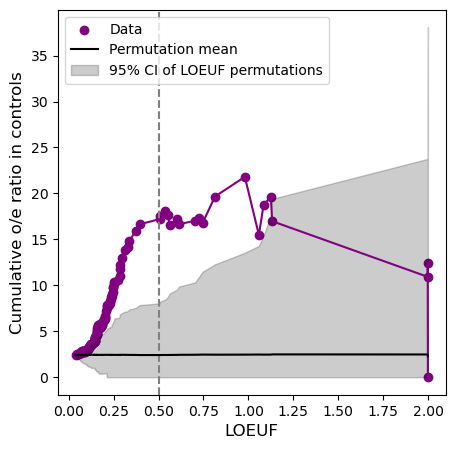

In [7]:
# Cumulative signal vs LOEUF in controls
data_dir = "/Users/misha/Documents/metaanalysis/clonal_expansions/rebuttal1/"

crit_FDR = 0.1
L = 17730

df_ASD_NDD = pd.read_csv(data_dir + "ASD_NDD_LoF_results.txt", sep="\t")

df_ASD_NDD = df_ASD_NDD.sort_values("P_val").reset_index(drop=True)

# Calculate the Benjamini-Hochberg critical value
df_ASD_NDD["BH_critical_value"] = (np.arange(1, len(df_ASD_NDD) + 1) / L) * crit_FDR

# Identify significant rows
df_ASD_NDD["Significant"] = df_ASD_NDD["P_val"] <= df_ASD_NDD["BH_critical_value"]

df_ASD_NDD = df_ASD_NDD[df_ASD_NDD["Significant"]].reset_index(drop=True)

df_CNTRL = pd.read_csv(data_dir + "CNTRL_LoF_results.txt", sep="\t")
df_CNTRL = df_CNTRL[df_CNTRL["ensembl_gene_id"].isin(df_ASD_NDD["ensembl_gene_id"])].reset_index(drop=True)

# Add LOEUF column from df_ASD_NDD to df_CNTRL by merging on "ensembl_gene_id"
df_CNTRL = df_CNTRL.merge(df_ASD_NDD[["ensembl_gene_id", "LOEUF"]], on="ensembl_gene_id", how="left")

CNTRL_lambda = np.sum(df_CNTRL["poisson_lambda"])
ASD_NDD_lambda = df_ASD_NDD[df_ASD_NDD["ensembl_gene_id"].isin(df_CNTRL["ensembl_gene_id"])]["poisson_lambda"].sum()

df_ASD_NDD["CNTRL_lambda"] = df_ASD_NDD["poisson_lambda"] * CNTRL_lambda / ASD_NDD_lambda

CNTRL_vc = {df_CNTRL["ensembl_gene_id"][i] : df_CNTRL["count"][i] for i in range(len(df_CNTRL))}

df_ASD_NDD["control_count"] = [CNTRL_vc[df_ASD_NDD["ensembl_gene_id"][i]] if CNTRL_vc.get(df_ASD_NDD["ensembl_gene_id"][i]) else 0 for i in range(len(df_ASD_NDD))]

# sort by LOEUF
df_ASD_NDD = df_ASD_NDD.sort_values("LOEUF", ascending = False).reset_index(drop=True)

# cumulative control_count/CNTRL_lambda
df_ASD_NDD["cumulative_control_count"] = np.cumsum(df_ASD_NDD["control_count"])
df_ASD_NDD["cumulative_CNTRL_lambda"] = np.cumsum(df_ASD_NDD["CNTRL_lambda"])
df_ASD_NDD["cumulative_control_count"] = df_ASD_NDD["cumulative_control_count"] / df_ASD_NDD["cumulative_CNTRL_lambda"]

plt.figure(figsize=(5, 5))
plt.scatter(df_ASD_NDD["LOEUF"], df_ASD_NDD["cumulative_control_count"], color="purple", label="Data")
plt.plot(df_ASD_NDD["LOEUF"], df_ASD_NDD["cumulative_control_count"], color="purple")
# vertical line at 0.5
plt.axvline(x=0.5, color='grey', linestyle='--')

# scramble the LOEUF values 100 times and repeat the plot
permut_arrs = []
for i in range(10000):
    df_ASD_NDD["LOEUF"] = np.random.permutation(df_ASD_NDD["LOEUF"])
    df_ASD_NDD = df_ASD_NDD.sort_values("LOEUF", ascending = False).reset_index(drop=True)
    df_ASD_NDD["cumulative_control_count"] = np.cumsum(df_ASD_NDD["control_count"])
    df_ASD_NDD["cumulative_CNTRL_lambda"] = np.cumsum(df_ASD_NDD["CNTRL_lambda"])
    df_ASD_NDD["cumulative_control_count"] = df_ASD_NDD["cumulative_control_count"] / df_ASD_NDD["cumulative_CNTRL_lambda"]
    #plt.scatter(df_ASD_NDD["LOEUF"], df_ASD_NDD["cumulative_control_count"], color="grey", alpha=0.1)
    #plt.plot(df_ASD_NDD["LOEUF"], df_ASD_NDD["cumulative_control_count"], color="grey", alpha=0.1, linestyle="--")
    permut_arrs.append(df_ASD_NDD["cumulative_control_count"])

permut_arrs = np.array(permut_arrs)
mean_permut_arr = np.mean(permut_arrs, axis=0)

CI_lower_arr = np.percentile(permut_arrs, 0.5, axis=0)
CI_upper_arr = np.percentile(permut_arrs, 99.5, axis=0)

plt.plot(df_ASD_NDD["LOEUF"], mean_permut_arr, color="black", label="Permutation mean")
plt.fill_between(df_ASD_NDD["LOEUF"], CI_lower_arr, CI_upper_arr, color="black", alpha=0.2, label="95% CI of LOEUF permutations")
#plt.fill_between(df_ASD_NDD["LOEUF"], mean_permut_arr - std_permut_arr, mean_permut_arr + std_permut_arr, color="black", alpha=0.2, label="Std dev permuted control count")

plt.xlabel("LOEUF", fontsize=12)
plt.ylabel("Cumulative o/e ratio in controls", fontsize=12)
plt.legend()
plt.savefig("Cumulative_control_count_vs_LOEUF.pdf")

#plt.title("Cumulative control count vs LOEUF", fontsize=16)

/var/folders/lp/tg73n10s4nz06fzkwth8fm440000gp/T/ipykernel_15798/2822570535.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(expected_p), -np.log10(sorted_p), alpha=0.5, color="blue")


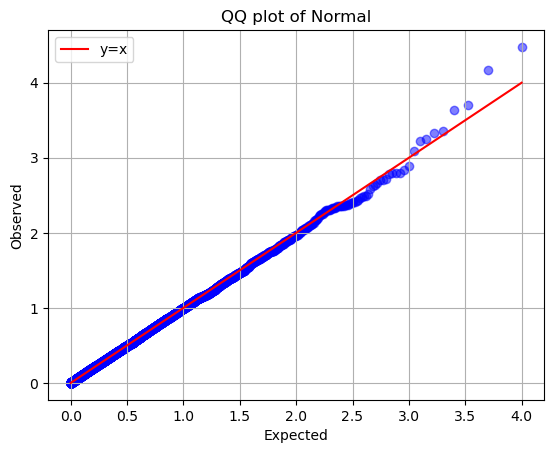

In [270]:
# test here the following: 
# Draw random samples from bivariate Normal distribution with mu = [0,0] and sigma = [[1, 0], [0, 1]], sum up the vectors
# and check the distribution of the sums

P_chk = []
for i in range(10000):
    x1 = np.random.normal(loc=0, scale=1, size=1)
    x2 = np.random.normal(loc=0, scale=1, size=1)
    x = x1 + x2

    background = np.random.normal(loc=0, scale=1, size=30000) + np.random.normal(loc=0, scale=1, size=30000)
    P = np.sum(background <= x) / len(background)
    P_chk.append(P)

QQ_plot(P_chk, fr"QQ plot of Normal")

In [44]:
def sum_of_k_products(arr, k):
    n = len(arr)
    dp = [ [0] * (k + 1) for _ in range(n + 1) ]
    for i in range(n + 1):
        dp[i][0] = 1  # Base case: product of zero elements is 1

    for i in range(1, n + 1):
        for j in range(1, min(i, k) + 1):
            dp[i][j] = dp[i - 1][j] + arr[i - 1] * dp[i - 1][j - 1]

    return dp[n][k]

arr = [1, 2, 3, 4]
k = 3
result = sum_of_k_products(arr, k)
print(result) 

50
